In [352]:
import pandas as pd
import numpy as np
import MySQLdb
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from astropy.table import QTable, Table

In [354]:
db = MySQLdb.connect(host='104.154.94.28',db='loganp',\
                     read_default_file="~/.my.cnf",\
                     autocommit=True,\
                     local_infile = 1)
c=db.cursor()

In [3]:
def get_targets(ra,dec,ang_diam,project,name,dist=5000,con=db,database='master_gaia_database'):
    """
    Given an RA/Dec array of any size, returns a Pandas databse of
    the targets from the master database that fall within 
    a circle of specified angular diameter of the given RA/Decs
    All angles in degrees
    Args:
        ra,dec (array, float [deg]): arrays of pointing coordinates in decimal degrees
        ang_diam (float [deg]): angular size of the diameter of the beam you are simulating.  Default of 0.8 deg
                          is slightly smaller than the MeerKAT beam in L-band to provide a conservative estimate
        project (string): project name that this pointing came from
        name (string): name of the primary beam target
        dist (float, [pc]): depth of the desired query in parsecs.  Default is set larger than the largest distance
                          in the master database to return essentially no distance cut
        con (MySQL connection object): the connection you would like to use for the retrieval
        database (str): the database to query.  Default is the master database of all Gaia targets in our program
    Returns:
        Pandas dataframe of every object in the database meeting criteria
    """
    index = range(len(ra))
    appended_data = [] #make a list to store dataframes
    for r,d,i in zip(ra,dec,index):
        string = 'SELECT * FROM '+str(database)+' \
                    WHERE POWER((ra-('+str(r)+')),2) + POWER((decl - ('+str(d)+')),2) < '+str((ang_diam/2.)**2)+' \
                    AND `dist.c` <= '+str(dist)+';'
        dataframe = pd.read_sql(string, con=con)
        dataframe['project']=project
        dataframe['name']=name
        # store DataFrame in list
        appended_data.append(dataframe)
        print "I've done ",i+1," of ",len(ra)," total pointings"
    targets = pd.concat(appended_data, axis=0)
    return targets

def find_exoplanets(ra,dec,ang_diam):
    """
    Given an RA/Dec array of any size, queries the NASA Exoplanet Archive and returns a Pandas databse of
    any known exoplanet hosts that fall within a circle of specified angular diameter of the given RA/Decs
    All angles in degrees
    Args:
        ra,dec (array, float [deg]): arrays of pointing coordinates in decimal degrees
        ang_diam (float [deg]): angular size of the diameter of the beam you are simulating.  Default of 0.8 deg
                          is slightly smaller than the MeerKAT beam in L-band to provide a conservative estimate
    Returns:
        Astropy table object of every confirmed exoplanet host within the circle.
    """
    from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
    from astropy.table import QTable, Table
    # Get exoplanet archive table of all confirmed exoplanets:
    result_table = NasaExoplanetArchive.get_confirmed_planets_table()
    # Convert QTable to regular astropy Table object for easy referencing:
    e = Table(result_table)
    # Convert to pandas df
    cols = e.colnames[0:len(e.colnames)-1]
    ee = e[cols].filled(-9999)
    e = ee.to_pandas()
    
    # Create array for results:
    appended_data = []
    for r,d in zip(ra,dec):
        circle = ((r)-(e['ra']))**2 + ((d)-(e['dec']))**2 <= ang_diam**2
        appended_data.append(e[circle])
    exoplanets = pd.concat(appended_data, axis=0)
    return exoplanets

### All of our Gaia targets within FOV

In [355]:
string = 'SELECT ra,decl FROM master_gaia_database \
                    WHERE decl BETWEEN -90.0 and 45.0;'
dataframe = pd.read_sql(string, con=db)

### All the pulsars in the ATNF catalog within FOV:

In [76]:
# All the pulsars in ATNF catalog within dec -90 & 45:
k=pd.read_csv('../atnf_all_psr_lessthan45dec.csv',delimiter=';',comment='#')
k

,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,POSEPOCH,ELONG,...,BSURF,EDOT,EDOTD2,PMTOT,VTRANS,P1_I,AGE_I,BSURF_I,B_LC,Unnamed: 69
0,1,J0006+1834,J0006+1834,00:06:04.8,+18:34:59,*,*,*,49079.50,8.986,...,1.22e+12,2.48e+32,3.35e+32,*,*,*,*,*,3.43e+01,NaN
1,2,J0011+08,J0011+08,00:11:34,+08:10,*,*,*,57022.00,5.909,...,*,*,*,*,*,*,*,*,*,NaN
2,3,J0024-7201Z,J0024-7201Z,00:24:06.0,-72:05:01.4,4.000,1.000,*,51600.00,311.248,...,*,*,*,4.123,50.042,-5.02e-21,-1.44e+10,NaN,*,NaN
3,4,J0024-7204aa,J0024-7204aa,00:24:05.6,-72:04:52.6,*,*,*,57022.00,311.252,...,*,*,*,*,*,*,*,*,*,NaN
4,5,J0024-7204ab,J0024-7204ab,00:24:08.1,-72:04:47.6,4.200,-2.900,*,51600.00,311.259,...,1.93e+08,7.62e+33,1.18e+33,5.104,61.462,9.22e-21,6.36e+09,1.87e+08,3.56e+04,NaN
5,6,B0021-72D,J0024-7204D,00:24:13.8,-72:04:43.8,4.240,-2.240,*,51600.00,311.269,...,*,*,*,4.795,106.625,-4.83e-21,-1.76e+10,NaN,*,NaN
6,7,B0021-72E,J0024-7204E,00:24:11.1,-72:05:20.1,6.150,-2.350,*,51600.00,311.246,...,5.97e+08,8.79e+34,4.00e+33,6.584,146.389,9.68e-20,5.79e+08,5.92e+08,1.27e+05,NaN
7,8,B0021-72F,J0024-7204F,00:24:03.8,-72:04:42.8,4.520,-2.500,*,51600.00,311.255,...,4.16e+08,1.41e+35,6.41e+33,5.165,114.851,6.37e-20,6.53e+08,4.14e+08,2.16e+05,NaN
8,9,B0021-72G,J0024-7204G,00:24:07.9,-72:04:39.7,4.500,-2.900,*,51600.00,311.262,...,*,*,*,5.354,119.036,-4.35e-20,-1.47e+09,NaN,*,NaN
9,10,B0021-72H,J0024-7204H,00:24:06.7,-72:04:06.8,5.100,-2.800,*,51600.00,311.277,...,*,*,*,5.818,129.366,-3.07e-21,-1.66e+10,NaN,*,NaN


### Parkes Pulsar Timing Array targets:

In [4]:
# Get Parkes Pulsar Timing Array objects
from astroquery.simbad import Simbad
# Reardon+ 2016
ppta = Simbad.query_bibobj('2016MNRAS.455.1751R')
t = Table()
t['RA'] = ppta['RA']
t['DEC'] = ppta['DEC']
t['NAME'] = ppta['MAIN_ID']

ppta=t.to_pandas()
#ppta

In [5]:
# Convert to degrees:
ra = ppta['RA'].values
dec = ppta['DEC'].values
radeg,decdeg = np.zeros(len(ra)),np.zeros(len(dec))
for r,d,i in zip(ra,dec,range(len(ra))):
    sc = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg), equinox='J2000.0')
    radeg[i],decdeg[i] = sc.ra.degree,sc.dec.degree
ppta['ra_deg'],ppta['dec_deg'] = radeg,decdeg
ppta

,RA,DEC,NAME,ra_deg,dec_deg
0,04 37 15.9314,-47 15 09.318,PSR J0437-47,69.316381,-47.252588
1,06 13 43.9759,-02 00 47.228,PSR B0613-02.0,93.433233,-2.013119
2,07 11 54.2007,-68 30 47.473,PSR J0712-68,107.975836,-68.513187
3,10 22 58.011,+10 01 52.85,PSR J1022+10,155.741712,10.031347
4,10 24 38.697,-07 19 19.07,PSR J1024-0719,156.161237,-7.321964
5,10 45 50.1894,-45 09 54.143,PSR J1045-45,161.459122,-45.165040
6,16 00 51.9040,-30 53 49.319,PSR J1600-3053,240.216267,-30.897033
7,16 03 35.6798,-72 02 32.698,PSR J1604-72,240.898666,-72.042416
8,16 43 38.1558,-12 24 58.720,PSR J1643-1224,250.908982,-12.416311
9,17 13 49.5305,+07 47 37.526,PSR J1713+0447,258.456377,7.793757


In [22]:
ppta.to_csv('ppta_targets.csv')

<IPython.core.display.Javascript object>


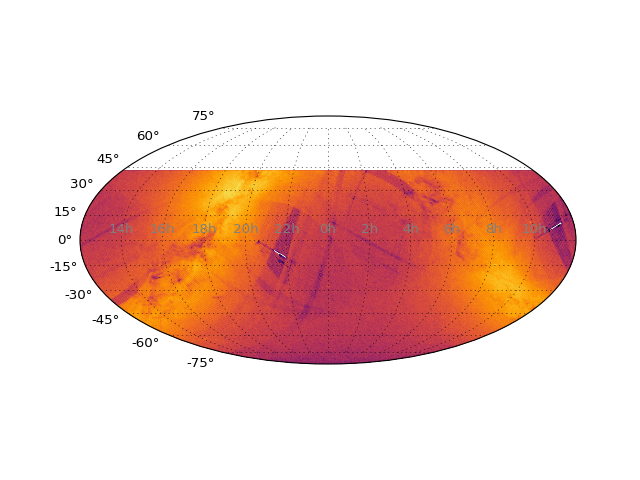

In [356]:
from astropy.coordinates import Angle
pra = Angle(ppta['ra_deg'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = Angle(ppta['dec_deg'].values*u.degree)

#mpra = Angle(m['RAJD'].values*u.degree)[0:100]
#mpra = mpra.wrap_at(180*u.degree)
#mpdec = Angle(m['DECJD'].values*u.degree)[0:100]

hbra = Angle(dataframe['ra'].values*u.degree)
hbra = hbra.wrap_at(180*u.degree)
hbdec = Angle(dataframe['decl'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(hbra.radian, hbdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
#ax.scatter(pra.radian, pdec.radian,alpha=0.7,color='orange',s=10, label='PPTA pulsars')
#ax.scatter(mpra.radian, mpdec.radian,alpha=0.7,color='blue',s=10, label='100 brightest MSPs')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
#ax.set_title('MeerTime MSP pointings \n')
#cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
#cb.set_label('log10(count)')
ax.grid(True)
plt.show()
#plt.legend(fontsize=12,loc=4)
plt.savefig('meerkat_fov_mollweide.png',format='png',dpi=300)

In [117]:
# Get all PPTA targets within each pointing:
targets = get_targets(ppta['ra_deg'].values,ppta['dec_deg'].values,ang_diam=0.8)

I've done  1  of  21  total pointings
I've done  2  of  21  total pointings
I've done  3  of  21  total pointings
I've done  4  of  21  total pointings
I've done  5  of  21  total pointings
I've done  6  of  21  total pointings
I've done  7  of  21  total pointings
I've done  8  of  21  total pointings
I've done  9  of  21  total pointings
I've done  10  of  21  total pointings
I've done  11  of  21  total pointings
I've done  12  of  21  total pointings
I've done  13  of  21  total pointings
I've done  14  of  21  total pointings
I've done  15  of  21  total pointings
I've done  16  of  21  total pointings
I've done  17  of  21  total pointings
I've done  18  of  21  total pointings
I've done  19  of  21  total pointings
I've done  20  of  21  total pointings
I've done  21  of  21  total pointings


In [118]:
targets.to_csv('our_targets/meertime_ppta.csv')

### NanoGrav targets

All Nanograv targets that are observed by GBT or AO+Parkes PTA

In [177]:
k=pd.read_csv('../atnf_all_psr_lessthan45dec.csv',delimiter=';',comment='#')
print np.where(k['NAME']=='J0023+0923')

(array([1506]),)


In [178]:
n = pd.read_table('Nanograv.txt',comment='#')
#n

In [179]:
nanograv1=n.loc[np.where(n['Observatory']=='GBT')[0]]
nanograv2=n.loc[np.where(n['Observatory']=='AO/GBT')[0]]
nanograv=pd.concat([nanograv1,nanograv2])
nanograv

,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N
2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41
3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217
4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53
5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53
6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236
7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120
8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232
9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173
10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134
12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236


In [180]:
nanograv['RA'],nanograv['Dec']="NaN","NaN"

In [181]:
for i in range(len(nanograv)):
    t = Simbad.query_object('PSR '+str(nanograv['Name'].values[i]))
    t = Table(t)
    t = t.to_pandas()
    try:
        nanograv['RA'].values[i] = t['RA'].values[0]
        nanograv['Dec'].values[i] = t['DEC'].values[0]
    except:
        pass
nanograv

,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec
2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300
3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN
4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53,06 45 59.0819,+51 58 14.921
5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN
6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236,10 12 33.4341,+53 07 02.564
7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN
8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN
9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN
10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN
12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN


In [182]:
ra = nanograv['RA'].values
dec = nanograv['Dec'].values
radeg,decdeg = np.zeros(len(ra)),np.zeros(len(dec))
for r,d,i in zip(ra,dec,range(len(ra))):
    try:
        sc = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg), equinox='J2000.0')
        radeg[i],decdeg[i] = sc.ra.degree,sc.dec.degree
    except:
        radeg[i],decdeg[i] = 'NaN','NaN'
nanograv['ra_deg'],nanograv['dec_deg'] = radeg,decdeg

In [160]:
nanograv=nanograv.reset_index()
nanograv

,index,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg
0,2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300,55.097036,41.512583
1,3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN,NaN,NaN
2,4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53,06 45 59.0819,+51 58 14.921,101.496175,51.970811
3,5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN,NaN,NaN
4,6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236,10 12 33.4341,+53 07 02.564,153.139309,53.117379
5,7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN,NaN,NaN
6,8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN,NaN,NaN
7,9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN,NaN,NaN
8,10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN,NaN,NaN
9,12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN,NaN,NaN


In [175]:
name = 'J2145−0750'
g=pd.read_table('NANOGrav_11y/par/J2145-0750_NANOGrav_11yv1.gls.par',delim_whitespace=True,nrows=2,\
                header=None,skiprows=1,usecols=[1])
g
l,b=g.values[0],g.values[1]
print l[0],b[0]
sc = SkyCoord(l=l[0]*u.degree, b=b[0]*u.degree, frame='galactic')
print sc
sc.icrs.ra.degree
nanograv=nanograv.set_value(np.where(nanograv['Name']==name)[0][0],'ra_deg',sc.icrs.ra.degree)
nanograv=nanograv.set_value(np.where(nanograv['Name']==name)[0][0],'dec_deg',sc.icrs.dec.degree)
nanograv

326.024617374 5.31305421569
<SkyCoord (Galactic): (l, b) in deg
    ( 326.02461737,  5.31305422)>


/Users/loganpearce/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/loganpearce/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,index,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg
0,2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300,55.097036,41.512583
1,3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN,342.193321,30.435679
2,4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53,06 45 59.0819,+51 58 14.921,101.496175,51.970811
3,5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN,40.258773,24.754377
4,6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236,10 12 33.4341,+53 07 02.564,153.139309,53.117379
5,7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN,57.705768,33.352239
6,8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN,96.132836,-23.342751
7,9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN,108.188165,-32.445414
8,10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN,118.035961,-29.520491
9,12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN,131.815462,-27.671369


In [293]:
nanograv=pd.read_csv('nanograv_targets.csv')
nanograv

,Unnamed: 0,Unnamed: 0.1,index,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg
0,0,0,2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300,55.097036,41.512583
1,1,1,3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN,342.193321,30.435679
2,2,2,4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53,06 45 59.0819,+51 58 14.921,101.496175,51.970811
3,3,3,5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN,40.258773,24.754377
4,4,4,6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236,10 12 33.4341,+53 07 02.564,153.139309,53.117379
5,5,5,7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN,57.705768,33.352239
6,6,6,8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN,96.132836,-23.342751
7,7,7,9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN,108.188165,-32.445414
8,8,8,10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN,118.035961,-29.520491
9,9,9,12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN,131.815462,-27.671369


In [294]:
nanograv=nanograv.drop(index=[2,4],axis=0)
nanograv=nanograv.reset_index()
nanograv

,level_0,Unnamed: 0,Unnamed: 0.1,index,Name,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg
0,0,0,0,2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300,55.097036,41.512583
1,1,1,1,3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN,342.193321,30.435679
2,3,3,3,5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN,40.258773,24.754377
3,5,5,5,7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN,57.705768,33.352239
4,6,6,6,8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN,96.132836,-23.342751
5,7,7,7,9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN,108.188165,-32.445414
6,8,8,8,10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN,118.035961,-29.520491
7,9,9,9,12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN,131.815462,-27.671369
8,10,10,10,16,J1744−1134,4.07,3.1,GBT,820/1500,0.198,0.22,53216,8.8,226,NaN,NaN,145.463725,-37.168900
9,11,11,11,17,J1747−4036,1.65,152.9,GBT,820/1500,—,—,55976,1.2,41,NaN,NaN,112.316419,-55.920421


In [290]:
print n['dec_deg']

0     41.512583
1     30.435679
3     24.754377
5     33.352239
6    -23.342751
7    -32.445414
8    -29.520491
9    -27.671369
10   -37.168900
11   -55.920421
12   -68.882734
13   -45.790549
14   -56.366658
15   -50.618133
16    44.706139
17     7.793757
18    21.622778
Name: dec_deg, dtype: float64


In [176]:
nanograv.to_csv('nanograv_targets.csv',index=False)

In [ ]:
# Get all Nanograv targets within each pointing:
targets = get_targets(nanograv['ra_deg'].values,nanograv['dec_deg'].values,ang_diam=0.8)

In [219]:
print ppta.shape,nanograv.shape
print ppta.shape[0]+nanograv.shape[0]

(21, 5) (19, 14)
40


### Other bright MPSs

In [228]:
# Get just the MSPs:
m=k.loc[np.where((k['P0'].values<'0.01')&(k['P0'].values>='0.001'))[0]]
m=m.reset_index()
m

,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,POSEPOCH,...,BSURF,EDOT,EDOTD2,PMTOT,VTRANS,P1_I,AGE_I,BSURF_I,B_LC,Unnamed: 69
0,2,3,J0024-7201Z,J0024-7201Z,00:24:06.0,-72:05:01.4,4.000,1.000,*,51600.00,...,*,*,*,4.123,50.042,-5.02e-21,-1.44e+10,NaN,*,NaN
1,3,4,J0024-7204aa,J0024-7204aa,00:24:05.6,-72:04:52.6,*,*,*,57022.00,...,*,*,*,*,*,*,*,*,*,NaN
2,4,5,J0024-7204ab,J0024-7204ab,00:24:08.1,-72:04:47.6,4.200,-2.900,*,51600.00,...,1.93e+08,7.62e+33,1.18e+33,5.104,61.462,9.22e-21,6.36e+09,1.87e+08,3.56e+04,NaN
3,5,6,B0021-72D,J0024-7204D,00:24:13.8,-72:04:43.8,4.240,-2.240,*,51600.00,...,*,*,*,4.795,106.625,-4.83e-21,-1.76e+10,NaN,*,NaN
4,6,7,B0021-72E,J0024-7204E,00:24:11.1,-72:05:20.1,6.150,-2.350,*,51600.00,...,5.97e+08,8.79e+34,4.00e+33,6.584,146.389,9.68e-20,5.79e+08,5.92e+08,1.27e+05,NaN
5,7,8,B0021-72F,J0024-7204F,00:24:03.8,-72:04:42.8,4.520,-2.500,*,51600.00,...,4.16e+08,1.41e+35,6.41e+33,5.165,114.851,6.37e-20,6.53e+08,4.14e+08,2.16e+05,NaN
6,8,9,B0021-72G,J0024-7204G,00:24:07.9,-72:04:39.7,4.500,-2.900,*,51600.00,...,*,*,*,5.354,119.036,-4.35e-20,-1.47e+09,NaN,*,NaN
7,9,10,B0021-72H,J0024-7204H,00:24:06.7,-72:04:06.8,5.100,-2.800,*,51600.00,...,*,*,*,5.818,129.366,-3.07e-21,-1.66e+10,NaN,*,NaN
8,10,11,B0021-72I,J0024-7204I,00:24:07.9,-72:04:39.6,5.000,-2.100,*,51600.00,...,*,*,*,5.423,120.583,-4.70e-20,-1.17e+09,NaN,*,NaN
9,11,12,B0021-72J,J0024-7204J,00:23:59.4,-72:03:58.7,5.270,-3.590,*,51600.00,...,*,*,*,6.377,141.784,-1.08e-20,-3.09e+09,NaN,*,NaN


In [200]:
m.to_csv('MeerTime_msp_all_MSP_atnfcatalog.csv',index=False)

In [229]:
# Scott said any MSPs below -35 Dec because Parkes discovered them and they will have been too faint to time previously
mm = m.loc[np.where(m['DECJD']<-35)[0]]
mm=mm.reset_index()
print mm.shape

(89, 72)


In [234]:
print np.where(mm['S1400']>'0')[0].shape
mmm = mm.loc[np.where(mm['S1400']>'0')[0]]
mmm

(43,)


,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,BSURF,EDOT,EDOTD2,PMTOT,VTRANS,P1_I,AGE_I,BSURF_I,B_LC,Unnamed: 69
46,147,748,749,J0437-4715,J0437-4715,04:37:15.8,-47:15:09.1,121.439,-71.475,6.370,...,5.81e+08,1.19e+34,4.82e+35,140.911,104.745,1.37e-20,6.64e+09,2.85e+08,2.85e+04,NaN
47,152,860,861,J2241-5236,J2241-5236,22:41:42.0,-52:36:36.2,*,*,*,...,1.22e+08,2.51e+34,2.72e+34,*,*,*,*,*,1.09e+05,NaN
48,156,893,894,J0711-6830,J0711-6830,07:11:54.1,-68:30:47.4,-15.570,14.240,*,...,2.90e+08,3.55e+33,2.94e+35,21.100,11.004,1.43e-20,6.10e+09,2.83e+08,1.64e+04,NaN
49,160,922,923,J1045-4509,J1045-4509,10:45:50.1,-45:09:54.1,-6.070,5.200,2.200,...,3.68e+08,1.67e+33,1.44e+34,7.993,12.884,1.73e-20,6.86e+09,3.64e+08,8.26e+03,NaN
50,161,923,924,J1652-48,J1652-48,16:52:54,-48:45,*,*,*,...,*,*,*,*,*,*,*,*,*,NaN
51,165,948,949,J1933-6211,J1933-6211,19:33:32.4,-62:11:46.8,-5.540,10.700,*,...,1.19e+08,3.43e+33,8.13e+33,12.049,37.131,3.06e-21,1.84e+10,1.05e+08,2.50e+04,NaN
52,166,963,964,J1909-3744,J1909-3744,19:09:47.4,-37:44:14.4,-9.517,-35.797,0.810,...,2.06e+08,2.16e+34,1.66e+34,37.040,200.193,2.83e-21,1.65e+10,9.24e+07,7.54e+04,NaN
53,170,1007,1008,J1732-5049,J1732-5049,17:32:47.7,-50:49:00.1,-0.410,-9.870,*,...,2.78e+08,3.74e+33,1.07e+33,9.879,87.579,1.18e-20,7.11e+09,2.54e+08,1.74e+04,NaN
54,173,1052,1053,J1421-4409,J1421-4409,14:21:20.9,-44:09:04.5,-10.000,3.000,*,...,2.88e+08,1.93e+33,4.45e+32,10.440,102.954,9.18e-21,1.10e+10,2.45e+08,1.04e+04,NaN
55,175,1069,1070,J1708-3506,J1708-3506,17:08:17.6,-35:06:22.6,-5.300,-2.000,*,...,2.30e+08,4.93e+33,4.47e+32,5.665,89.164,1.03e-20,6.96e+09,2.18e+08,2.35e+04,NaN


In [235]:
mmm.to_csv('new_parkes_targets.csv',index=False)

In [236]:
print nanograv.shape[0]+ppta.shape[0]+mmm.shape[0]

83


### Other bright MSPs

The goal is to get to 100. Matthew Bailes said 100 of the brightest MSPs will be observed.  Scott said the ones in the three groups above will definitely be observed.  So I will get the brightest of the remaining MSPs as a list of possibles

In [240]:
s = m.loc[np.where(m['S1400']>'0')[0]]
s=s.reset_index()

In [244]:
n=nanograv.rename(columns={'Name':'NAME'})
n

,NAME,Period,DM,Observatory,Frequencies,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg
2,J0340+4130,3.30,49.6,GBT,820/1500,—,—,55972,1.3,41,03 40 23.2887,+41 30 45.300,55.097036,41.512583
3,J0613−0200,3.06,38.8,GBT,820/1500,0.178,0.30,53348,8.4,217,NaN,NaN,NaN,NaN
4,J0645+5158,8.85,18.2,GBT,820/1500,—,—,55700,2.0,53,06 45 59.0819,+51 58 14.921,101.496175,51.970811
5,J0931−1902,4.64,41.5,GBT,820/1500,—,—,56351,0.2,53,NaN,NaN,NaN,NaN
6,J1012+5307,5.26,9.0,GBT,820/1500,0.276,0.67,51012,14.8,236,10 12 33.4341,+53 07 02.564,153.139309,53.117379
7,J1024−0719,5.16,6.5,GBT,820/1500,—,—,55094,3.7,120,NaN,NaN,NaN,NaN
8,J1455−3330,7.99,13.6,GBT,820/1500,0.787,2.35,53217,8.8,232,NaN,NaN,NaN,NaN
9,J1600−3053,3.60,52.3,GBT,820/1500,0.163,0.34,54400,5.6,173,NaN,NaN,NaN,NaN
10,J1614−2230,3.15,34.5,GBT,820/1500,—,—,54724,4.7,134,NaN,NaN,NaN,NaN
12,J1643−1224,4.62,62.4,GBT,820/1500,1.467,0.67,53217,8.8,236,NaN,NaN,NaN,NaN


In [242]:
# Taking the top 100
s=s[0:100]

In [246]:
# Remove targets already on PPTA or Nanograv list:
# Left merge the MSPs dataframe with the Nanograv dataframe on the Name column:
df_all = s.merge(n.drop_duplicates(), on=['NAME'], 
                   how='left', indicator=True)
df_all

,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg,_merge
0,147,748,749,J0437-4715,J0437-4715,04:37:15.8,-47:15:09.1,121.439,-71.475,6.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,148,774,775,B1937+21,J1939+2134,19:39:38.5,+21:34:59.1,0.070,-0.401,0.220,...,—,—,45985/53216,28.6/8.8,1001/233,19 39 39.6,+21 37 22,294.915000,21.622778,both
2,149,786,787,J1713+0747,J1713+0747,17:13:49.5,+07:47:37.4,*,*,0.810,...,0.030,0.08,48738/53798,21.2/7.2,659/212,17 13 49.5305,+07 47 37.526,258.456377,7.793757,both
3,150,839,840,B1855+09,J1857+0943,18:57:36.3,+09:43:17.1,*,*,0.610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,151,844,845,J1643-1224,J1643-1224,16:43:38.1,-12:24:58.6,5.940,3.940,1.270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,152,860,861,J2241-5236,J2241-5236,22:41:42.0,-52:36:36.2,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,153,868,869,J2317+1439,J2317+1439,23:17:09.2,+14:39:31.2,*,*,0.490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,154,871,872,J1730-2304,J1730-2304,17:30:21.6,-23:04:31.1,20.264,8.300,1.190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,155,884,885,J2124-3358,J2124-3358,21:24:43.8,-33:58:44.8,-14.140,-50.080,2.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,156,893,894,J0711-6830,J0711-6830,07:11:54.1,-68:30:47.4,-15.570,14.240,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [252]:
# Drop any rows that appear on both dataframes.
s = df_all.drop(df_all[df_all['_merge'] == 'both'].index)
s

,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,RMSASP,"~σt, ASP",MJD,T,N,RA,Dec,ra_deg,dec_deg,_merge
0,147,748,749,J0437-4715,J0437-4715,04:37:15.8,-47:15:09.1,121.439,-71.475,6.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,150,839,840,B1855+09,J1857+0943,18:57:36.3,+09:43:17.1,*,*,0.610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,151,844,845,J1643-1224,J1643-1224,16:43:38.1,-12:24:58.6,5.940,3.940,1.270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,152,860,861,J2241-5236,J2241-5236,22:41:42.0,-52:36:36.2,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,153,868,869,J2317+1439,J2317+1439,23:17:09.2,+14:39:31.2,*,*,0.490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,154,871,872,J1730-2304,J1730-2304,17:30:21.6,-23:04:31.1,20.264,8.300,1.190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,155,884,885,J2124-3358,J2124-3358,21:24:43.8,-33:58:44.8,-14.140,-50.080,2.400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,156,893,894,J0711-6830,J0711-6830,07:11:54.1,-68:30:47.4,-15.570,14.240,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
10,157,894,895,J0751+1807,J0751+1807,07:51:09.1,+18:07:38.4,-2.730,-13.400,0.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
11,158,901,902,J1744-1134,J1744-1134,17:44:29.4,-11:34:54.6,18.790,-9.400,2.530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [257]:
for name,i in zip(ppta['NAME'],range(len(ppta['NAME']))):
    print name.replace('PSR ','')
    ppta['NAME'].values[i]=name.replace('PSR ','')

J0437-47
B0613-02.0
J0712-68
J1022+10
J1024-0719
J1045-45
J1600-3053
J1604-72
J1643-1224
J1713+0447
J1730-2304
J1732-5049
J1744-1134
J1824-2452A
M  28
B1855+09
J1909-3744
B1937+21
J2124-3358
J2129-5718
B2145-07.8


In [267]:
s=s.drop('_merge',axis=1)

In [268]:
# Repeat for Parkes:
df_all = s.merge(ppta.drop_duplicates(), on=['NAME'], 
                   how='left', indicator=True)
df_all

,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,dec_deg_x,RA_y,DEC_x,ra_deg_y,dec_deg_y,RA,DEC_y,ra_deg,dec_deg,_merge
0,147,748,749,J0437-4715,J0437-4715,04:37:15.8,-47:15:09.1,121.439,-71.475,6.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,152,860,861,J2241-5236,J2241-5236,22:41:42.0,-52:36:36.2,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,153,868,869,J2317+1439,J2317+1439,23:17:09.2,+14:39:31.2,*,*,0.490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,156,893,894,J0711-6830,J0711-6830,07:11:54.1,-68:30:47.4,-15.570,14.240,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,157,894,895,J0751+1807,J0751+1807,07:51:09.1,+18:07:38.4,-2.730,-13.400,0.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,159,920,921,J2051-0827,J2051-0827,20:51:07.5,-08:27:37.7,5.630,2.340,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,160,922,923,J1045-4509,J1045-4509,10:45:50.1,-45:09:54.1,-6.070,5.200,2.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,161,923,924,J1652-48,J1652-48,16:52:54,-48:45,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,162,931,932,J1944+0907,J1944+0907,19:44:09.3,+09:07:23.0,*,*,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,164,943,944,J0613-0200,J0613-0200,06:13:43.9,-02:00:47.2,*,*,0.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [269]:
s = df_all.drop(df_all[df_all['_merge'] == 'both'].index)
s

,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,dec_deg_x,RA_y,DEC_x,ra_deg_y,dec_deg_y,RA,DEC_y,ra_deg,dec_deg,_merge
0,147,748,749,J0437-4715,J0437-4715,04:37:15.8,-47:15:09.1,121.439,-71.475,6.370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,152,860,861,J2241-5236,J2241-5236,22:41:42.0,-52:36:36.2,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,153,868,869,J2317+1439,J2317+1439,23:17:09.2,+14:39:31.2,*,*,0.490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,156,893,894,J0711-6830,J0711-6830,07:11:54.1,-68:30:47.4,-15.570,14.240,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,157,894,895,J0751+1807,J0751+1807,07:51:09.1,+18:07:38.4,-2.730,-13.400,0.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,159,920,921,J2051-0827,J2051-0827,20:51:07.5,-08:27:37.7,5.630,2.340,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,160,922,923,J1045-4509,J1045-4509,10:45:50.1,-45:09:54.1,-6.070,5.200,2.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,161,923,924,J1652-48,J1652-48,16:52:54,-48:45,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,162,931,932,J1944+0907,J1944+0907,19:44:09.3,+09:07:23.0,*,*,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,164,943,944,J0613-0200,J0613-0200,06:13:43.9,-02:00:47.2,*,*,0.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [270]:
# remove the ones with decl < -35 deg:
s = s.loc[np.where(s['DECJD']>-35)[0]]
s

,level_0,index,Unnamed: 0,NAME,PSRJ,RAJ,DECJ,PMRA,PMDEC,PX,...,dec_deg_x,RA_y,DEC_x,ra_deg_y,dec_deg_y,RA,DEC_y,ra_deg,dec_deg,_merge
2,153,868,869,J2317+1439,J2317+1439,23:17:09.2,+14:39:31.2,*,*,0.490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,157,894,895,J0751+1807,J0751+1807,07:51:09.1,+18:07:38.4,-2.730,-13.400,0.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,159,920,921,J2051-0827,J2051-0827,20:51:07.5,-08:27:37.7,5.630,2.340,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,162,931,932,J1944+0907,J1944+0907,19:44:09.3,+09:07:23.0,*,*,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,164,943,944,J0613-0200,J0613-0200,06:13:43.9,-02:00:47.2,*,*,0.930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
11,167,970,971,B1257+12,J1300+1240,13:00:03.5,+12:40:56.4,45.500,-84.700,1.410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
12,168,973,974,J1640+2224,J1640+2224,16:40:16.7,+22:24:08.8,*,*,0.660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
13,169,980,981,B1821-24A,J1824-2452A,18:24:32.0,-24:52:10.8,-0.690,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
14,171,1030,1031,J2010-1323,J2010-1323,20:10:45.9,-13:23:56.0,*,*,0.350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
16,174,1058,1059,J1748-3009,J1748-3009,17:48:23.7,-30:09:12.2,*,*,*,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


Now there's 55 left over.  Perfect.  I'll take all of those as possible targets.

In [272]:
s.to_csv('remaining_possible_msp_targets.csv',index=False)

In [ ]:
from astropy.coordinates import Angle
pra = Angle(ppta['ra_deg'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = Angle(ppta['dec_deg'].values*u.degree)

npra = Angle(nanograv['ra

<IPython.core.display.Javascript object>


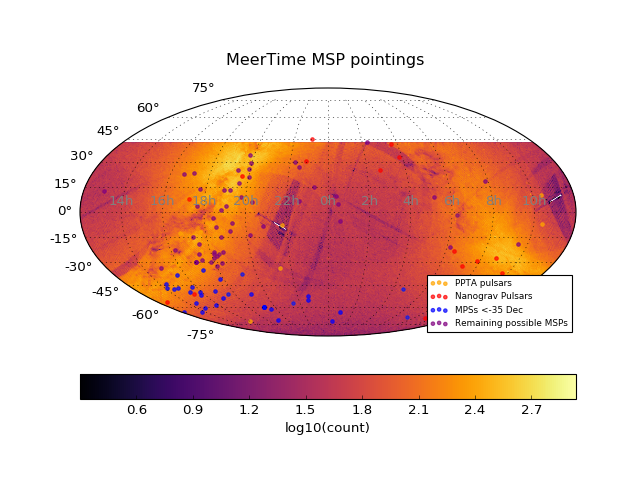

In [295]:
from astropy.coordinates import Angle
pra = Angle(ppta['ra_deg'].values*u.degree)
pra = pra.wrap_at(180*u.degree)
pdec = Angle(ppta['dec_deg'].values*u.degree)

npra = Angle(nanograv['ra_deg'].values*u.degree)
npra = npra.wrap_at(180*u.degree)
npdec = Angle(nanograv['dec_deg'].values*u.degree)

mpra = Angle(mmm['RAJD'].values*u.degree)
mpra = mpra.wrap_at(180*u.degree)
mpdec = Angle(mmm['DECJD'].values*u.degree)

spra = Angle(s['RAJD'].values*u.degree)
spra = spra.wrap_at(180*u.degree)
spdec = Angle(s['DECJD'].values*u.degree)

hbra = Angle(dataframe['ra'].values*u.degree)
hbra = hbra.wrap_at(180*u.degree)
hbdec = Angle(dataframe['decl'].values*u.degree)

%matplotlib notebook
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
hb = ax.hexbin(hbra.radian, hbdec.radian,gridsize=500,cmap='inferno',bins='log',mincnt=1)
ax.scatter(pra.radian, pdec.radian,alpha=0.7,color='orange',s=10, label='PPTA pulsars')
ax.scatter(npra.radian, npdec.radian,alpha=0.7,color='red',s=10, label='Nanograv Pulsars')
ax.scatter(mpra.radian, mpdec.radian,alpha=0.7,color='blue',s=10, label='MPSs <-35 Dec')
ax.scatter(spra.radian, spdec.radian,alpha=0.7,color='purple',s=10, label='Remaining possible MSPs')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'],color='grey')
ax.set_title('MeerTime MSP pointings \n')
cb = fig.colorbar(hb, ax=ax,orientation="horizontal", pad=0.1)
cb.set_label('log10(count)')
ax.grid(True)
plt.show()
plt.legend(fontsize=8,loc=4)
plt.savefig('meertime_msp_pointings_mollweide.png',format='png',dpi=300)

Put it all into one list

In [340]:
ppta=pd.read_csv('ppta_targets.csv')
ppta['label']='PPTA'
nanograv=pd.read_csv('nanograv_targets.csv')
nanograv['label']='Nanograv'
mmm = pd.read_csv('new_parkes_targets.csv')
mmm['label']='MSPs <-35 decl'
s=pd.read_csv('remaining_possible_msp_targets.csv')
s['label']='Possible MSP targets'

In [341]:
for name,i in zip(ppta['NAME'],range(len(ppta['NAME']))):
    ppta['NAME'].values[i]=name.replace('PSR ','')

In [342]:
nanograv=nanograv.rename(columns={'Name':'NAME'})

In [343]:
s=s.drop(columns=['ra_deg','dec_deg'])
s=s.rename(columns={'RAJD':'ra_deg','DECJD':'dec_deg'})

mmm=mmm.rename(columns={'RAJD':'ra_deg','DECJD':'dec_deg'})
#list(s)

In [346]:
master=pd.DataFrame(columns=['NAME','ra_deg','dec_deg','label'])
master=pd.concat([ppta[['NAME','ra_deg','dec_deg','label']], nanograv[['NAME','ra_deg','dec_deg','label']],\
                 mmm[['NAME','ra_deg','dec_deg','label']],s[['NAME','ra_deg','dec_deg','label']]],axis=0)
master

,NAME,ra_deg,dec_deg,label
0,J0437-47,69.316381,-47.252588,PPTA
1,B0613-02.0,93.433233,-2.013119,PPTA
2,J0712-68,107.975836,-68.513187,PPTA
3,J1022+10,155.741713,10.031347,PPTA
4,J1024-0719,156.161237,-7.321964,PPTA
5,J1045-45,161.459123,-45.165040,PPTA
6,J1600-3053,240.216267,-30.897033,PPTA
7,J1604-72,240.898666,-72.042416,PPTA
8,J1643-1224,250.908983,-12.416311,PPTA
9,J1713+0447,258.456377,7.793757,PPTA


In [347]:
master.to_csv('meertime_msp_targets.csv',index=False)